# Install transformers

In [ ]:
pip install transformers

# Build Tokeizer

In [ ]:
## load the vocabulary list into Bert tokenizer
from transformers import BertTokenizer
vocab_file = './100_java_20k_vocab.txt'
tokenizer = BertTokenizer(vocab_file = vocab_file, do_lower_case=False, do_basic_tokenize=False)
test_code = '▁( et pt'
print(tokenizer.encode(test_code))

[1, 7, 15, 72, 2]


# Sample Data

In [ ]:
## sample data from training set and validation set
## size of sampled training set: train_size
## size of sampled val set: val_size
import random
train_path_full = './java_100_repo_train_java_original_2_level_bpe_510'
val_path_full = './java_100_repo_validation_java_original_2_level_bpe_510'
train_path = './java_train.txt'
val_path = './java_val.txt'
train_full = []
val_full = []
train_size = 6000
val_size = 1000
with open(train_path_full, 'r', encoding='utf-8') as f:
  for line in f:
    res = line
    train_full.append(res)
print('training data loaded!')

with open(val_path_full, 'r', encoding='utf-8') as p:
  for item in p:
    res = item
    val_full.append(res)
print('val data loaded!')

sampled_train = random.sample(train_full, train_size)
sampled_val = random.sample(val_full, val_size)

with open(train_path, 'w', encoding='utf-8') as fp:
  for a in sampled_train:
    fp.write(a)

with open(val_path, 'w', encoding='utf-8') as pf:
  for b in sampled_val:
    pf.write(b)


# Process input data

In [ ]:
## load data with LineByLineTextDataset
from transformers import LineByLineTextDataset
train_path = './java_train.txt'
val_path = './java_val.txt'
train_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=train_path, 
    block_size=510
)
val_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=val_path,
    block_size=510
)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [ ]:
## Construct the data_collator
from transformers import DataCollatorForWholeWordMask
data_collator = DataCollatorForWholeWordMask(
    tokenizer=tokenizer,
    mlm_probability=0.15
)


# Model Configuration

In [ ]:
## load the Bert model
## Set up the training parameters.
from transformers import Trainer, AutoModelForMaskedLM, AutoConfig, TrainingArguments
model_config = AutoConfig.from_pretrained('bert-base-cased', cache_dir=None)
model = AutoModelForMaskedLM.from_pretrained(
    'bert-base-cased',
    from_tf=False,
    config=model_config,
    cache_dir=None
)
training_args = TrainingArguments(
    output_dir='pretrain_bert',
    overwrite_output_dir=True,
    do_train=True, 
    do_eval=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=10,
    evaluation_strategy='steps',
    logging_steps=50,
    eval_steps = None,
    prediction_loss_only=True,
    learning_rate = 5e-5,
    weight_decay=0,
    adam_epsilon = 1e-8,
    max_grad_norm = 1.0,
    num_train_epochs = 1,
    save_steps = -1,
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train the Bert

In [ ]:
trainer.train()
trainer.save_model()

***** Running training *****
  Num examples = 10000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2500


Step,Training Loss,Validation Loss
50,7.643400,6.580454
100,6.146700,5.447886
150,5.402900,5.007236
200,5.025000,4.837700
250,4.857700,4.535360
300,4.635300,4.300312
350,4.408500,4.155486
400,4.252900,3.969893
450,4.092700,3.802685
500,3.924700,3.644868


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
***** 

# Save the loss and perplexity

In [ ]:
## Keep track of train and evaluate loss.
## Compute perplexity.
import math
loss_history = {'train_loss':[], 'eval_loss':[]}

# Keep track of train and evaluate perplexity.
# This is a metric useful to track for language models.
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))
    
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))


In [ ]:
## Save loss history and perplexity history in TXT files.
import numpy as np
np.savetxt('train_loss_10000_4.txt', loss_history['train_loss'], delimiter =', ')
np.savetxt('eval_loss_10000_4.txt', loss_history['eval_loss'], delimiter =', ')
np.savetxt('train_per_10000_4.txt', perplexity_history['train_perplexity'], delimiter =', ')
np.savetxt('eval_per_10000_4.txt', perplexity_history['eval_perplexity'], delimiter =', ')

# Plot loss and perplexity

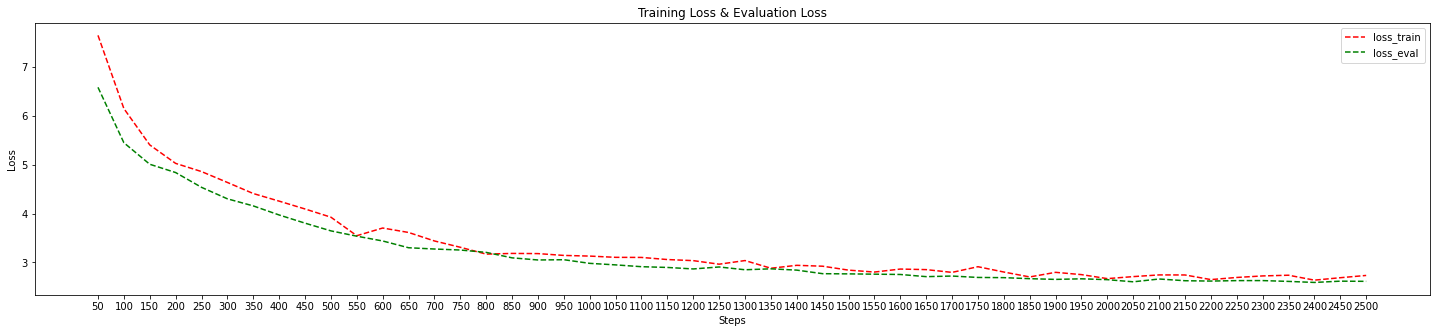

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


train_loss = np.loadtxt('train_loss_10000_4.txt')
eval_loss = np.loadtxt('eval_loss_10000_4.txt')
train_per = np.loadtxt('train_per_10000_4.txt')
eval_per = np.loadtxt('eval_per_10000_4.txt')

step_length = 50
step_stop = (len(train_loss)+1) * 50
steps = np.arange(50, step_stop, step_length)

fig = plt.figure(figsize=(25,5))

l1 = plt.plot(steps, train_loss, 'r--', label='loss_train')
l2 = plt.plot(steps, eval_loss, 'g--', label='loss_eval')

plt.title('Training Loss & Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xticks(steps)
plt.legend()
plt.show()

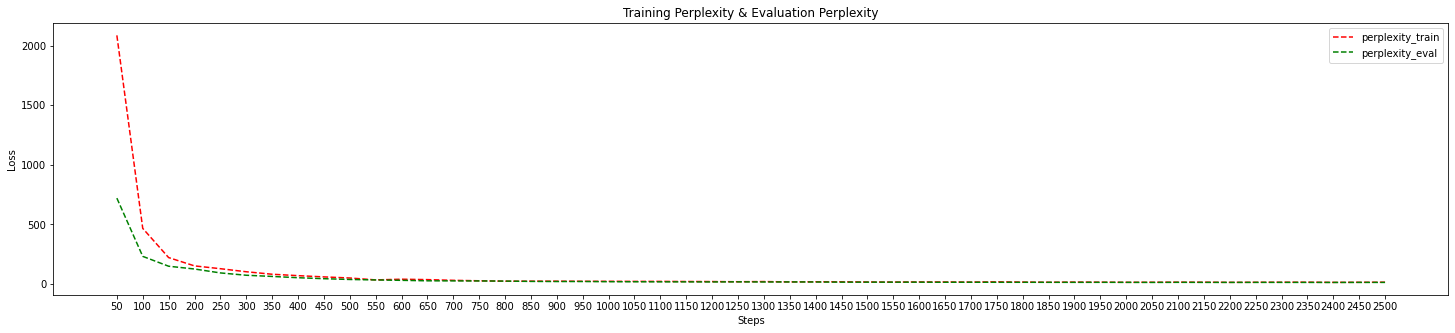

In [ ]:
fig = plt.figure(figsize=(25,5))

l1 = plt.plot(steps, train_per, 'r--', label='perplexity_train')
l2 = plt.plot(steps, eval_per, 'g--', label='perplexity_eval')

plt.title('Training Perplexity & Evaluation Perplexity')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xticks(steps)
plt.legend()
plt.show()

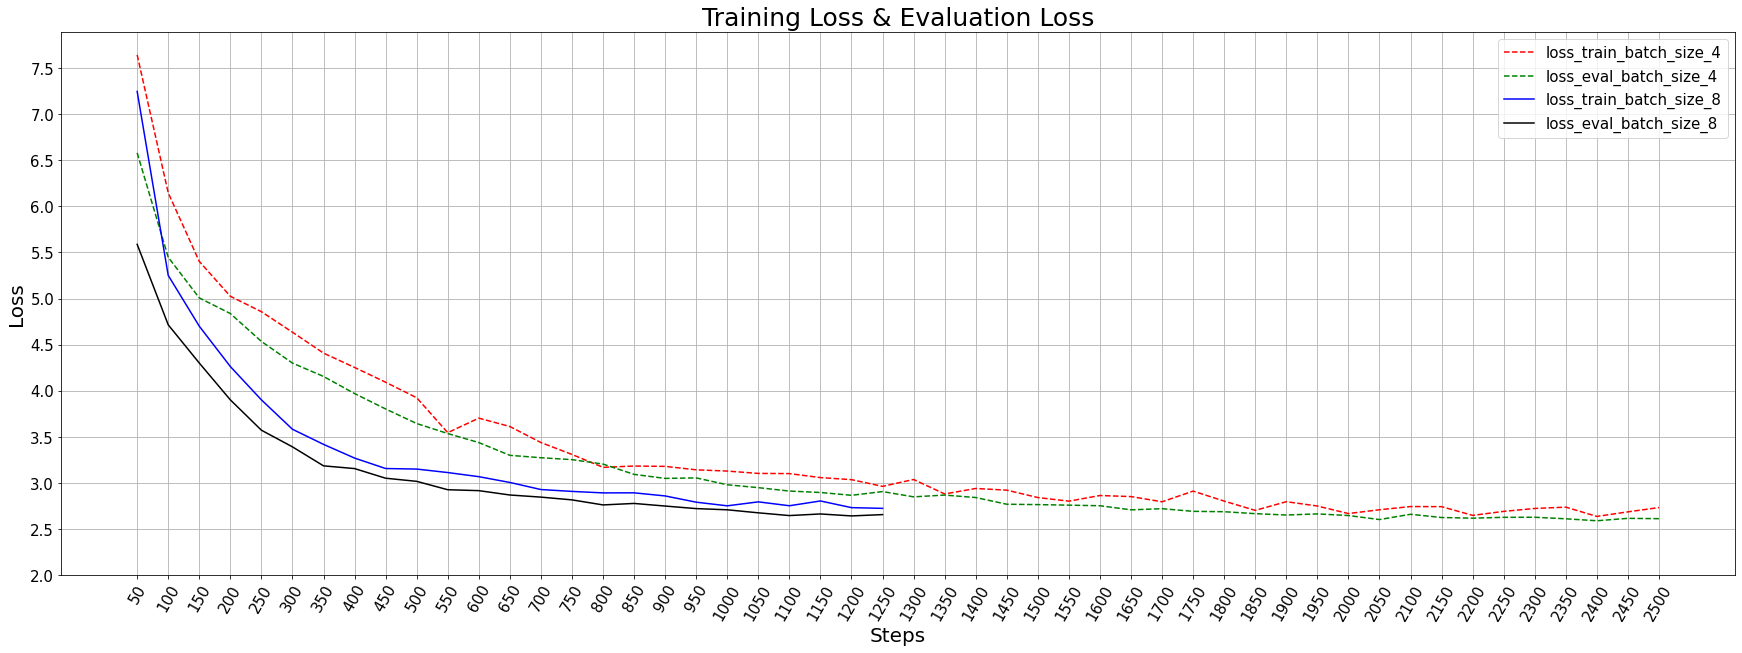

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,10))

train_loss_batch4 = np.loadtxt('train_loss_10000_4.txt')
train_loss_batch8 = np.loadtxt('train_loss_10000_8.txt')
eval_loss_batch4 = np.loadtxt('eval_loss_10000_4.txt')
eval_loss_batch8 = np.loadtxt('eval_loss_10000_8.txt')

step_length = 50
step_stop_batch4 = (len(train_loss_batch4)+1) * 50
steps_batch4 = np.arange(50, step_stop_batch4, step_length)
step_stop_batch8 = (len(train_loss_batch8)+1) * 50
steps_batch8 = np.arange(50, step_stop_batch8, step_length)

l1 = plt.plot(steps_batch4, train_loss_batch4, 'r--', label='loss_train_batch_size_4')
l2 = plt.plot(steps_batch4, eval_loss_batch4, 'g--', label='loss_eval_batch_size_4')

l3 = plt.plot(steps_batch8, train_loss_batch8, 'b', label='loss_train_batch_size_8')
l4 = plt.plot(steps_batch8, eval_loss_batch8, 'k', label='loss_eval_batch_size_8')

plt.title('Training Loss & Evaluation Loss', fontsize=25)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)

plt.xticks(steps_batch4, fontsize=15, rotation=60)
plt.yticks(np.arange(2, 8, 0.5), fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

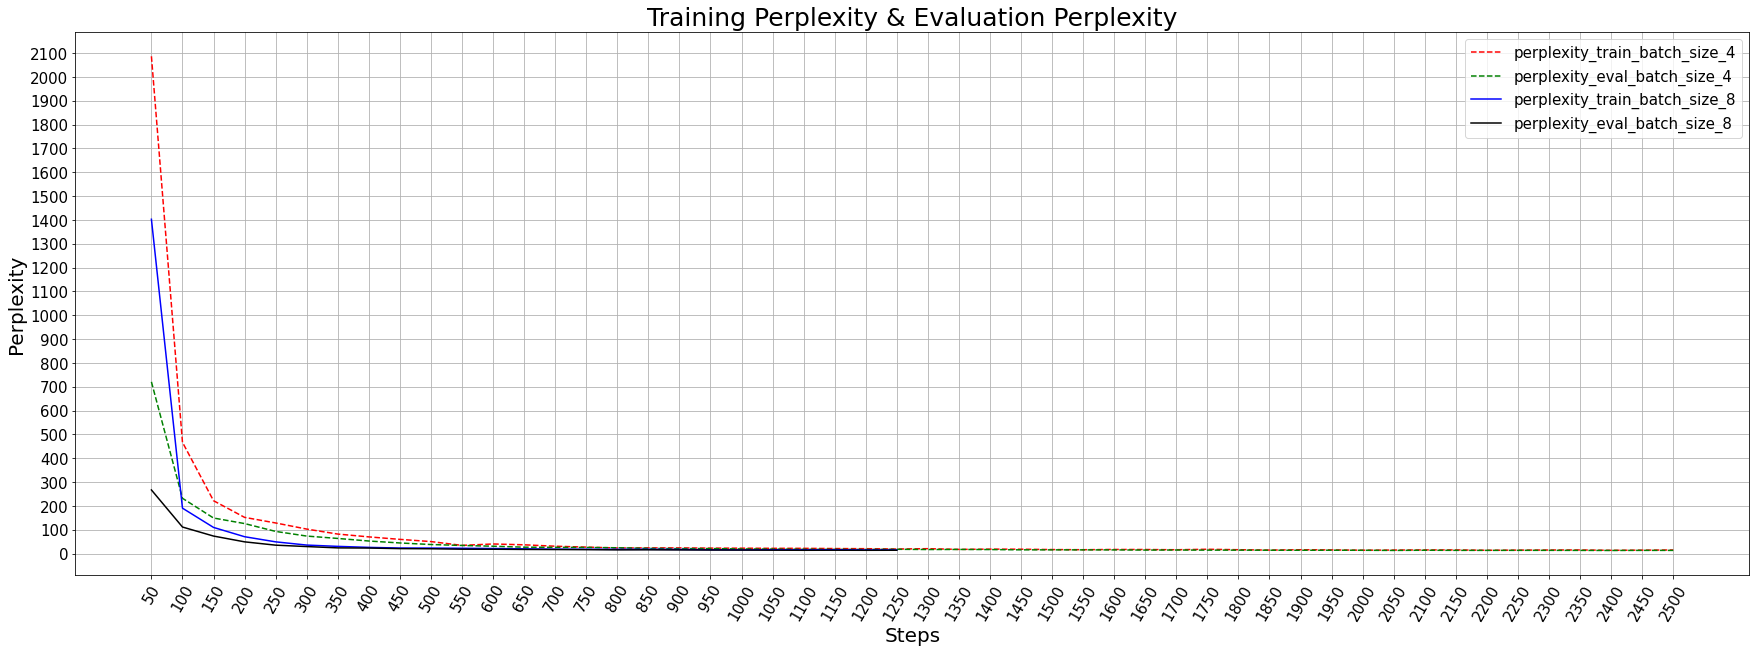

In [6]:
fig = plt.figure(figsize=(30,10))

train_per_batch4 = np.loadtxt('train_per_10000_4.txt')
train_per_batch8 = np.loadtxt('train_per_10000_8.txt')
eval_per_batch4 = np.loadtxt('eval_per_10000_4.txt')
eval_per_batch8 = np.loadtxt('eval_per_10000_8.txt')

step_length = 50
step_stop_batch4 = (len(train_per_batch4)+1) * 50
steps_batch4 = np.arange(50, step_stop_batch4, step_length)
step_stop_batch8 = (len(train_per_batch8)+1) * 50
steps_batch8 = np.arange(50, step_stop_batch8, step_length)

l1 = plt.plot(steps_batch4, train_per_batch4, 'r--', label='perplexity_train_batch_size_4')
l2 = plt.plot(steps_batch4, eval_per_batch4, 'g--', label='perplexity_eval_batch_size_4')

l3 = plt.plot(steps_batch8, train_per_batch8, 'b', label='perplexity_train_batch_size_8')
l4 = plt.plot(steps_batch8, eval_per_batch8, 'k', label='perplexity_eval_batch_size_8')

plt.title('Training Perplexity & Evaluation Perplexity', fontsize=25)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Perplexity', fontsize=20)

plt.xticks(steps_batch4, fontsize=15, rotation=60)
plt.yticks(np.arange(0, 2200, 100), fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()